In [1]:
import gymnasium as gym
from gymnasium import spaces

# PyTorch imports
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"
device_ = torch.device(device)
print(device, " in use")
torch.autograd.set_detect_anomaly(True)

# Utility librarues
import base64, io
import random
import pickle
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
from itertools import count

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

torch.cuda.get_device_name(0)

cuda  in use


'NVIDIA RTX A5500 Laptop GPU'

In [2]:
env = gym.make('CartPole-v1')

obs_space = 4
action_space = 2

In [3]:
class Actor_net(nn.Module):
    def __init__(self):
        super(Actor_net, self).__init__()
        self.layer1 = nn.Linear(obs_space, 128)
        self.hidden = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_space) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        action_prob = F.softmax(self.out(x), dim= -1) # softmax
        return action_prob

In [4]:
class Critic_net(nn.Module):
    def __init__(self):
        super(Critic_net, self).__init__()
        self.layer1 = nn.Linear(obs_space + 1, 128)
        self.hidden = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        Q_val = self.out(x)
        return Q_val

In [5]:
Actor = Actor_net().to(device)
Critic = Critic_net().to(device)

Actor_lr = 0.0001
Actor_optim = optim.SGD(Actor.parameters(), lr = Actor_lr)
Qsa_lr = 0.0001
Critic_optim = optim.SGD(Critic.parameters(), lr = Qsa_lr)

In [12]:
def save_everything():

    PATH = "cartpole_Actor_QAC.pth"
    torch.save(Actor.state_dict(), PATH)

    weights = Actor.state_dict()
    with open('cartpole_Actor_QAC.pkl', 'wb') as f:
        pickle.dump(weights, f)

    PATH = "cartpole_Critic_QAC.pth"
    torch.save(Critic.state_dict(), PATH)

    weights = Critic.state_dict()
    with open('cartpole_Critic_QAC.pkl', 'wb') as f:
        pickle.dump(weights, f)

    with open('cartpole_reward_epi_QAC.pkl', 'wb') as f:
        pickle.dump(reward_epi, f)

    with open('cartpole_avg_reward_QAC.pkl', 'wb') as f:
        pickle.dump(avg_reward, f)

# Load prev training data

In [6]:
PATH = "cartpole_Actor_QAC.pth"
Actor.load_state_dict(torch.load(PATH))

PATH = "cartpole_Critic_QAC.pth"
Critic.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [7]:
with open('cartpole_reward_epi_QAC.pkl', 'rb') as f:
    reward_epi = pickle.load(f)

with open('cartpole_avg_reward_QAC.pkl', 'rb') as f:
    avg_reward = pickle.load(f)

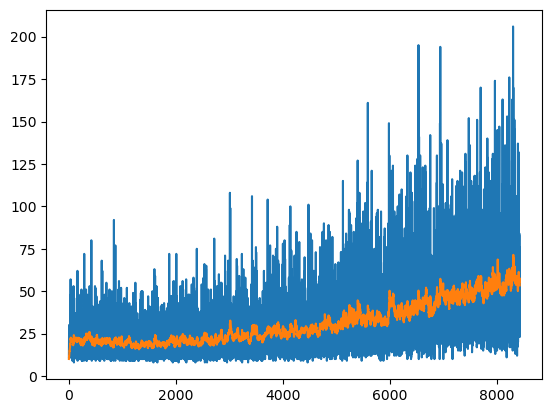

In [8]:
plt.plot(reward_epi, label = 'rew/epi')
plt.plot(avg_reward, label = 'avg_rew')

In [9]:
max_itr = 1000
gamma = 0.99

In [13]:
#reward_epi = []
#avg_reward = []
running_reward = 65
for cnt in count():
    obs, info = env.reset()
    terminated, truncated = False, False
    ep_reward = 0

    for i in range(max_itr):

        a_prob = Actor(torch.tensor(obs).float().to(device))
        a = torch.multinomial(a_prob, 1)
        a_log_prob = torch.log(a_prob[a]) 

        Qsa = Critic(torch.cat((torch.tensor(obs).to(device), a)).to(device))

        obs_next, reward, terminated, truncated, _ = env.step(a[0].detach().to("cpu").numpy())
        
        if terminated or truncated:
            expected = reward
        else:
            a_new_prob = Actor(torch.tensor(obs_next).float().to(device))
            a_next = torch.multinomial(a_new_prob, 1)
            Qsa_next = Critic(torch.cat((torch.tensor(obs_next).to(device), a_next)).to(device) )
            expected = reward + gamma*Qsa_next

        td_error = expected - Qsa

        Actor_loss = -a_log_prob*td_error.detach()
        Critic_loss = torch.square(expected - Qsa)

        Critic_optim.zero_grad()
        Critic_loss.backward()
        Critic_optim.step()

        Actor_optim.zero_grad()
        Actor_loss.backward()
        Actor_optim.step()

        

        obs = obs_next
        ep_reward += reward

        if truncated or terminated:
            reward_epi.append(ep_reward)
            break

    running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
    avg_reward.append(running_reward)

    if (cnt+1)% 10 == 0:
        plt.plot(reward_epi)
        plt.plot(avg_reward)
        plt.pause(0.001)

        display.display(plt.gcf())
        display.clear_output(wait=True)
    
    if (cnt+1)%100 == 0:
        save_everything()
    
    if running_reward > 450:
        break

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

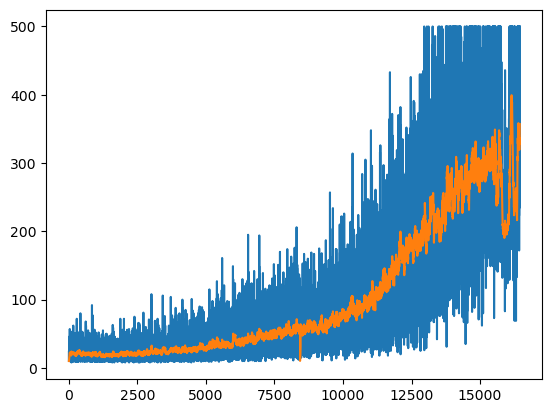

In [14]:
plt.plot(reward_epi, label = 'rew/epi')
plt.plot(avg_reward, label = 'avg_rew')

## Save

In [15]:
PATH = "cartpole_Actor_QAC.pth"
torch.save(Actor.state_dict(), PATH)

weights = Actor.state_dict()
with open('cartpole_Actor_QAC.pkl', 'wb') as f:
    pickle.dump(weights, f)

In [16]:
PATH = "cartpole_Critic_QAC.pth"
torch.save(Critic.state_dict(), PATH)

weights = Critic.state_dict()
with open('cartpole_Critic_QAC.pkl', 'wb') as f:
    pickle.dump(weights, f)

In [17]:
with open('cartpole_reward_epi_QAC.pkl', 'wb') as f:
    pickle.dump(reward_epi, f)

with open('cartpole_avg_reward_QAC.pkl', 'wb') as f:
    pickle.dump(avg_reward, f)

## Load

In [123]:
PATH = "cartpole_Actor_QAC.pth"
Actor.load_state_dict(torch.load(PATH))

PATH = "cartpole_Critic_QAC.pth"
Critic.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [121]:
with open('cartpole_reward_epi_QAC.pkl', 'rb') as f:
    reward_epi = pickle.load(f)

with open('cartpole_avg_reward_QAC.pkl', 'rb') as f:
    avg_reward = pickle.load(f)

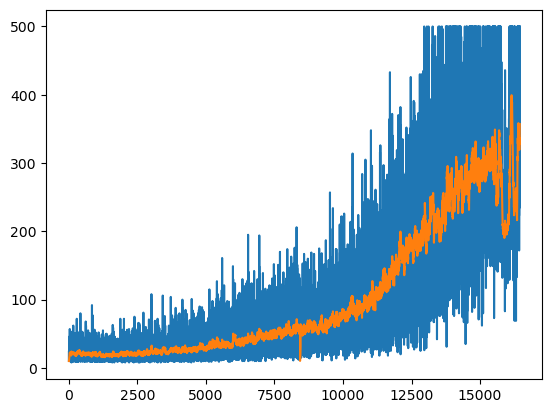

In [18]:
plt.plot(reward_epi, label = 'rew/epi')
plt.plot(avg_reward, label = 'avg_rew')

In [20]:
def give_action_greedy(obs, Actor_model):
    obs = torch.from_numpy(obs).float()
    probs = Actor_model(obs)
    max_val , idx = torch.max(probs, dim = -1)

    return idx.cpu().detach().numpy()

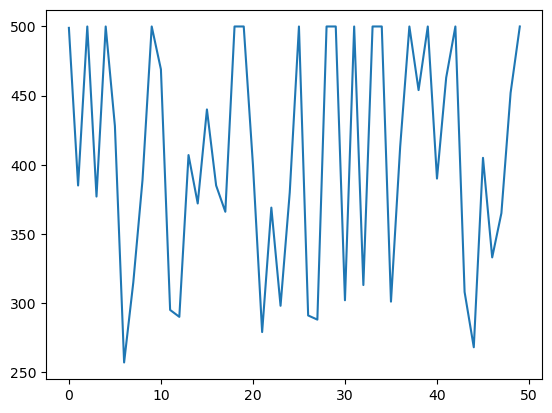

In [24]:
# There. we finished
# Lets see it in action
done = False
cnt = 0

env = gym.make('CartPole-v1' )#, render_mode="human")

observation, info = env.reset()

reward_arr_eval = []

for i in range(50):
    observation, info = env.reset()
    done = False
    cnt = 0
    reward_ = 0
    while True:

        cnt += 1
        #env.render()
        a_prob = Actor(torch.tensor(observation).float().to(device))
        a =  np.argmax( a_prob.detach().cpu().numpy() )
        observation, reward, ter, trun, _ = env.step(a)
        # Lets see how long it lasts until failing
        reward_ += reward
        if ter or trun:
            break
    reward_arr_eval.append(reward_)
    #print(f"Game lasted {cnt} moves")

env.close()
plt.plot(reward_arr_eval)